In [162]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
import warnings
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.utils.parallel import delayed
from sklearn.model_selection import GridSearchCV,KFold
import math
from sklearn.cluster import KMeans

In [116]:
x=pd.read_csv(r"C:\Users\maxen\Downloads\X_train_Wwou3IE.csv")
y=pd.read_csv(r"C:\Users\maxen\Downloads\y_train_jJtXgMX.csv")

In [117]:
print(y)

                  DELIVERY_START  spot_id_delta
0      2022-01-01 02:00:00+01:00     -36.874770
1      2022-01-01 03:00:00+01:00     -12.643588
2      2022-01-01 04:00:00+01:00      -1.950193
3      2022-01-01 05:00:00+01:00       1.938272
4      2022-01-01 06:00:00+01:00       0.199907
...                          ...            ...
10600  2023-03-29 19:00:00+02:00       6.029303
10601  2023-03-29 20:00:00+02:00      13.576177
10602  2023-03-29 21:00:00+02:00      17.478945
10603  2023-03-29 22:00:00+02:00      17.559407
10604  2023-03-29 23:00:00+02:00      16.503259

[10605 rows x 2 columns]


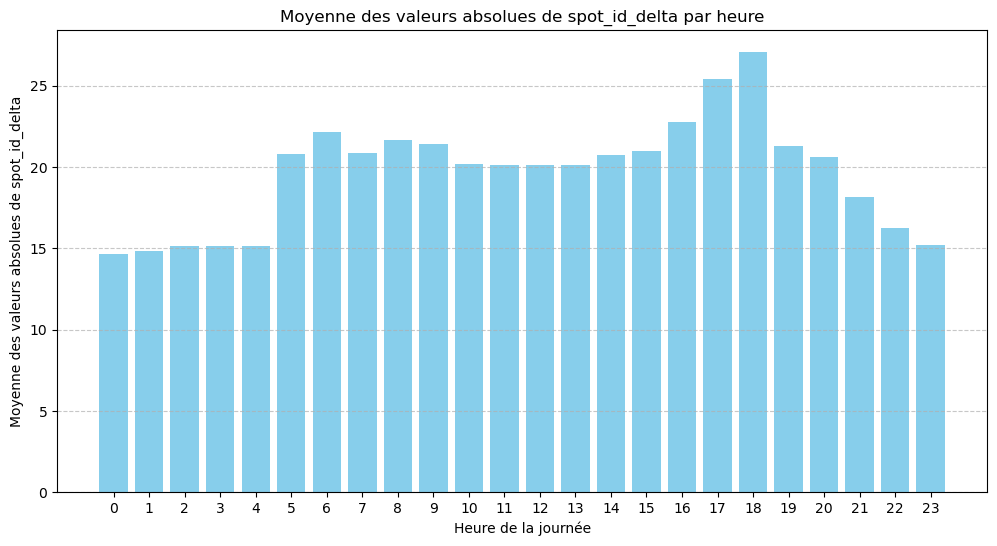

In [118]:

y['DELIVERY_START'] = pd.to_datetime(y['DELIVERY_START'], utc=True, errors='coerce')


y['hour'] = y['DELIVERY_START'].dt.hour

hourly_mean = y.groupby('hour')['spot_id_delta'].apply(lambda x: x.abs().mean()).reset_index()


plt.figure(figsize=(12, 6))
plt.bar(hourly_mean['hour'], hourly_mean['spot_id_delta'], color='skyblue')
plt.xlabel('Heure de la journée')
plt.ylabel('Moyenne des valeurs absolues de spot_id_delta')
plt.title('Moyenne des valeurs absolues de spot_id_delta par heure')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

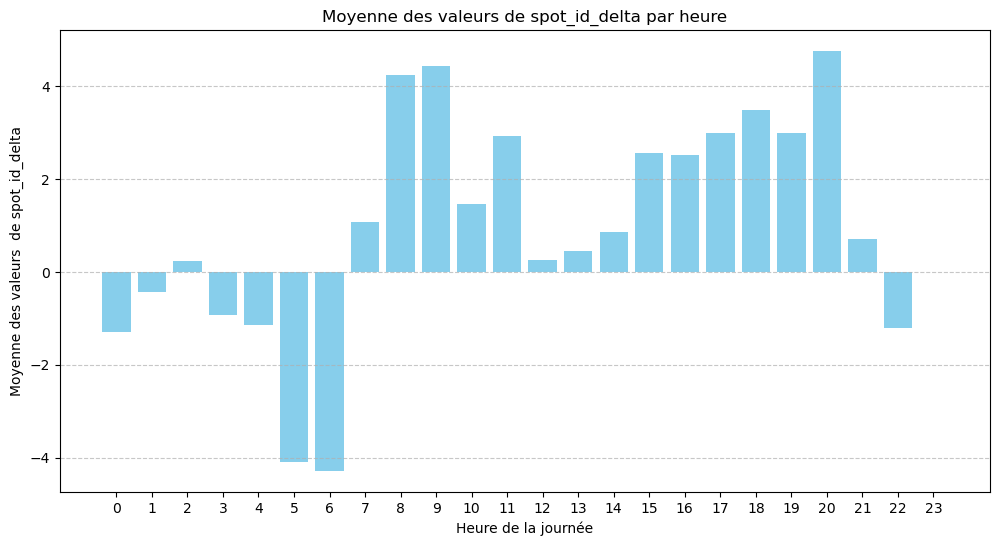

In [119]:

y['DELIVERY_START'] = pd.to_datetime(y['DELIVERY_START'], utc=True, errors='coerce')


y['hour'] = y['DELIVERY_START'].dt.hour

hourly_mean = y.groupby('hour')['spot_id_delta'].apply(lambda x: x.mean()).reset_index()


plt.figure(figsize=(12, 6))
plt.bar(hourly_mean['hour'], hourly_mean['spot_id_delta'], color='skyblue')
plt.xlabel('Heure de la journée')
plt.ylabel('Moyenne des valeurs  de spot_id_delta')
plt.title('Moyenne des valeurs de spot_id_delta par heure')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [120]:
y.drop("hour",axis=1)

,DELIVERY_START,spot_id_delta
0,2022-01-01 01:00:00+00:00,-36.874770
1,2022-01-01 02:00:00+00:00,-12.643588
2,2022-01-01 03:00:00+00:00,-1.950193
3,2022-01-01 04:00:00+00:00,1.938272
4,2022-01-01 05:00:00+00:00,0.199907
...,...,...
10600,2023-03-29 17:00:00+00:00,6.029303
10601,2023-03-29 18:00:00+00:00,13.576177
10602,2023-03-29 19:00:00+00:00,17.478945
10603,2023-03-29 20:00:00+00:00,17.559407


In [121]:
X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.1, random_state=42)

In [122]:
X_train.size

95440

In [123]:
y_train['spot_id_delta'] = np.where(y_train['spot_id_delta'] > 0, 1, 0)

In [124]:
y_validation['spot_id_delta'] = np.where(y_validation['spot_id_delta'] > 0, 1, 0)

In [125]:
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True, errors='coerce')
X_train['hour'] = X_train['DELIVERY_START'].dt.hour

In [126]:
X_validation['DELIVERY_START'] = pd.to_datetime(X_validation['DELIVERY_START'], utc=True, errors='coerce')
X_validation['hour'] = X_validation['DELIVERY_START'].dt.hour

In [127]:
X_train.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,hour
10251,2023-03-15 04:00:00+00:00,51399.0,3386.0,11945.0,38315.0,3797.0,0.0,333.500708,0.000000,106.60,4
4121,2022-06-28 17:00:00+00:00,48995.0,2226.0,10555.0,28620.0,1766.0,2477.0,112.254144,19.681975,NaN,17
8724,2023-01-09 13:00:00+00:00,61845.0,3386.0,11945.0,46265.0,13836.0,3474.0,53.666149,14.336867,143.64,13
1983,2022-03-26 07:00:00+00:00,49213.0,2806.0,11952.0,31035.0,5401.0,2690.0,45.263787,27.181849,NaN,7
3881,2022-06-18 17:00:00+00:00,46549.0,2226.0,10085.0,27285.0,3676.0,2384.0,306.774912,32.283700,NaN,17


In [128]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9544 entries, 10251 to 7270
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   DELIVERY_START                 9544 non-null   datetime64[ns, UTC]
 1   load_forecast                  8392 non-null   float64            
 2   coal_power_available           9543 non-null   float64            
 3   gas_power_available            9543 non-null   float64            
 4   nucelear_power_available       9543 non-null   float64            
 5   wind_power_forecasts_average   9523 non-null   float64            
 6   solar_power_forecasts_average  9522 non-null   float64            
 7   wind_power_forecasts_std       9523 non-null   float64            
 8   solar_power_forecasts_std      9522 non-null   float64            
 9   predicted_spot_price           1665 non-null   float64            
 10  hour                     

In [129]:
X_train['hour'] = X_train['hour'].astype('category')
X_validation['hour'] = X_validation['hour'].astype('category')


In [130]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9544 entries, 10251 to 7270
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   DELIVERY_START                 9544 non-null   datetime64[ns, UTC]
 1   load_forecast                  8392 non-null   float64            
 2   coal_power_available           9543 non-null   float64            
 3   gas_power_available            9543 non-null   float64            
 4   nucelear_power_available       9543 non-null   float64            
 5   wind_power_forecasts_average   9523 non-null   float64            
 6   solar_power_forecasts_average  9522 non-null   float64            
 7   wind_power_forecasts_std       9523 non-null   float64            
 8   solar_power_forecasts_std      9522 non-null   float64            
 9   predicted_spot_price           1665 non-null   float64            
 10  hour                     

In [131]:
cat_features=["hour"]

In [132]:
num_features=["load_forecast","coal_power_available","gas_power_available","nucelear_power_available", "wind_power_forecasts_average", "solar_power_forecasts_average","wind_power_forecasts_std","solar_power_forecasts_std","predicted_spot_price"]          

In [133]:
X_train.describe()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,8392.000000,9543.000000,9543.000000,9543.000000,9523.000000,9522.000000,9523.000000,9522.000000,1665.000000
mean,53713.266325,2819.043068,11462.351043,35381.610290,4519.070566,1919.468284,125.171640,25.065940,140.379610
std,11256.227224,495.489852,484.167103,7610.010427,3346.466738,2708.622077,132.068703,43.359295,34.023778
min,30628.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000
25%,45374.250000,2226.000000,11140.000000,29005.000000,2041.000000,0.000000,46.709958,0.000000,119.540000
50%,51804.500000,2806.000000,11487.000000,32467.000000,3319.000000,144.500000,86.686019,3.503731,140.100000
75%,62093.250000,3386.000000,11945.000000,43055.000000,5980.000000,3515.750000,155.180992,35.235595,161.090000
max,85145.000000,3391.000000,11963.000000,50122.000000,15167.000000,10127.000000,1871.571992,745.261316,254.190000


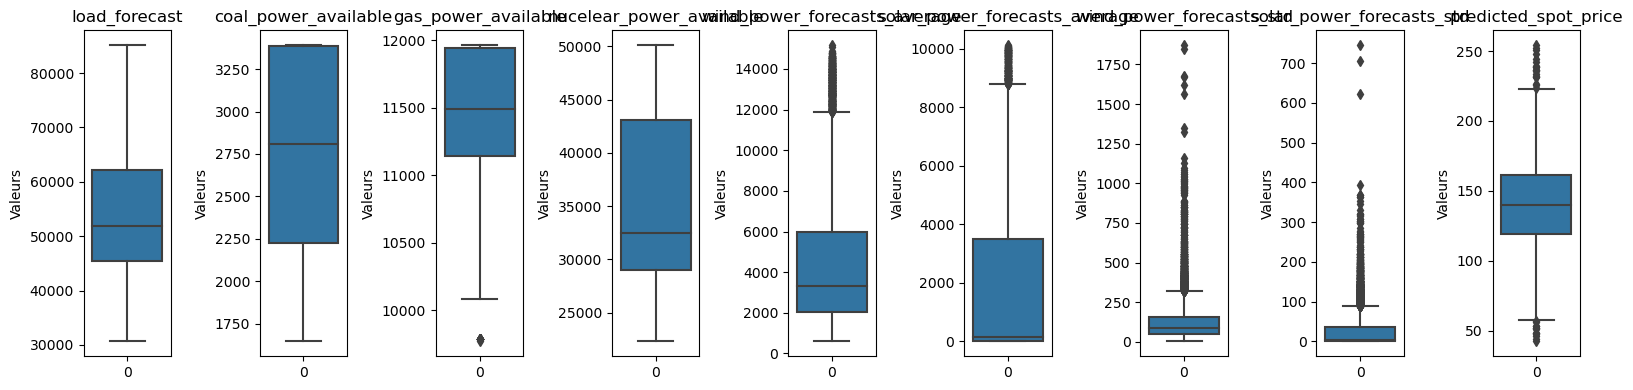

In [134]:

fig, axes = plt.subplots(1, 9, figsize=(16, 4))  # 1 ligne, 7 colonnes
for i, col in enumerate(X_train[num_features].columns):
    sns.boxplot(data=X_train[num_features][col], orient="v", ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Valeurs')


plt.tight_layout()

plt.show()

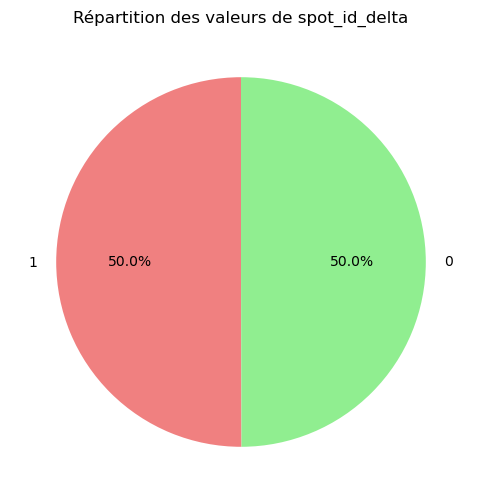

In [137]:
value_counts = y_train['spot_id_delta'].value_counts()

# Tracer le pie chart
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title("Répartition des valeurs de spot_id_delta")
plt.show()

In [138]:
print(value_counts)

spot_id_delta
1    4776
0    4768
Name: count, dtype: int64


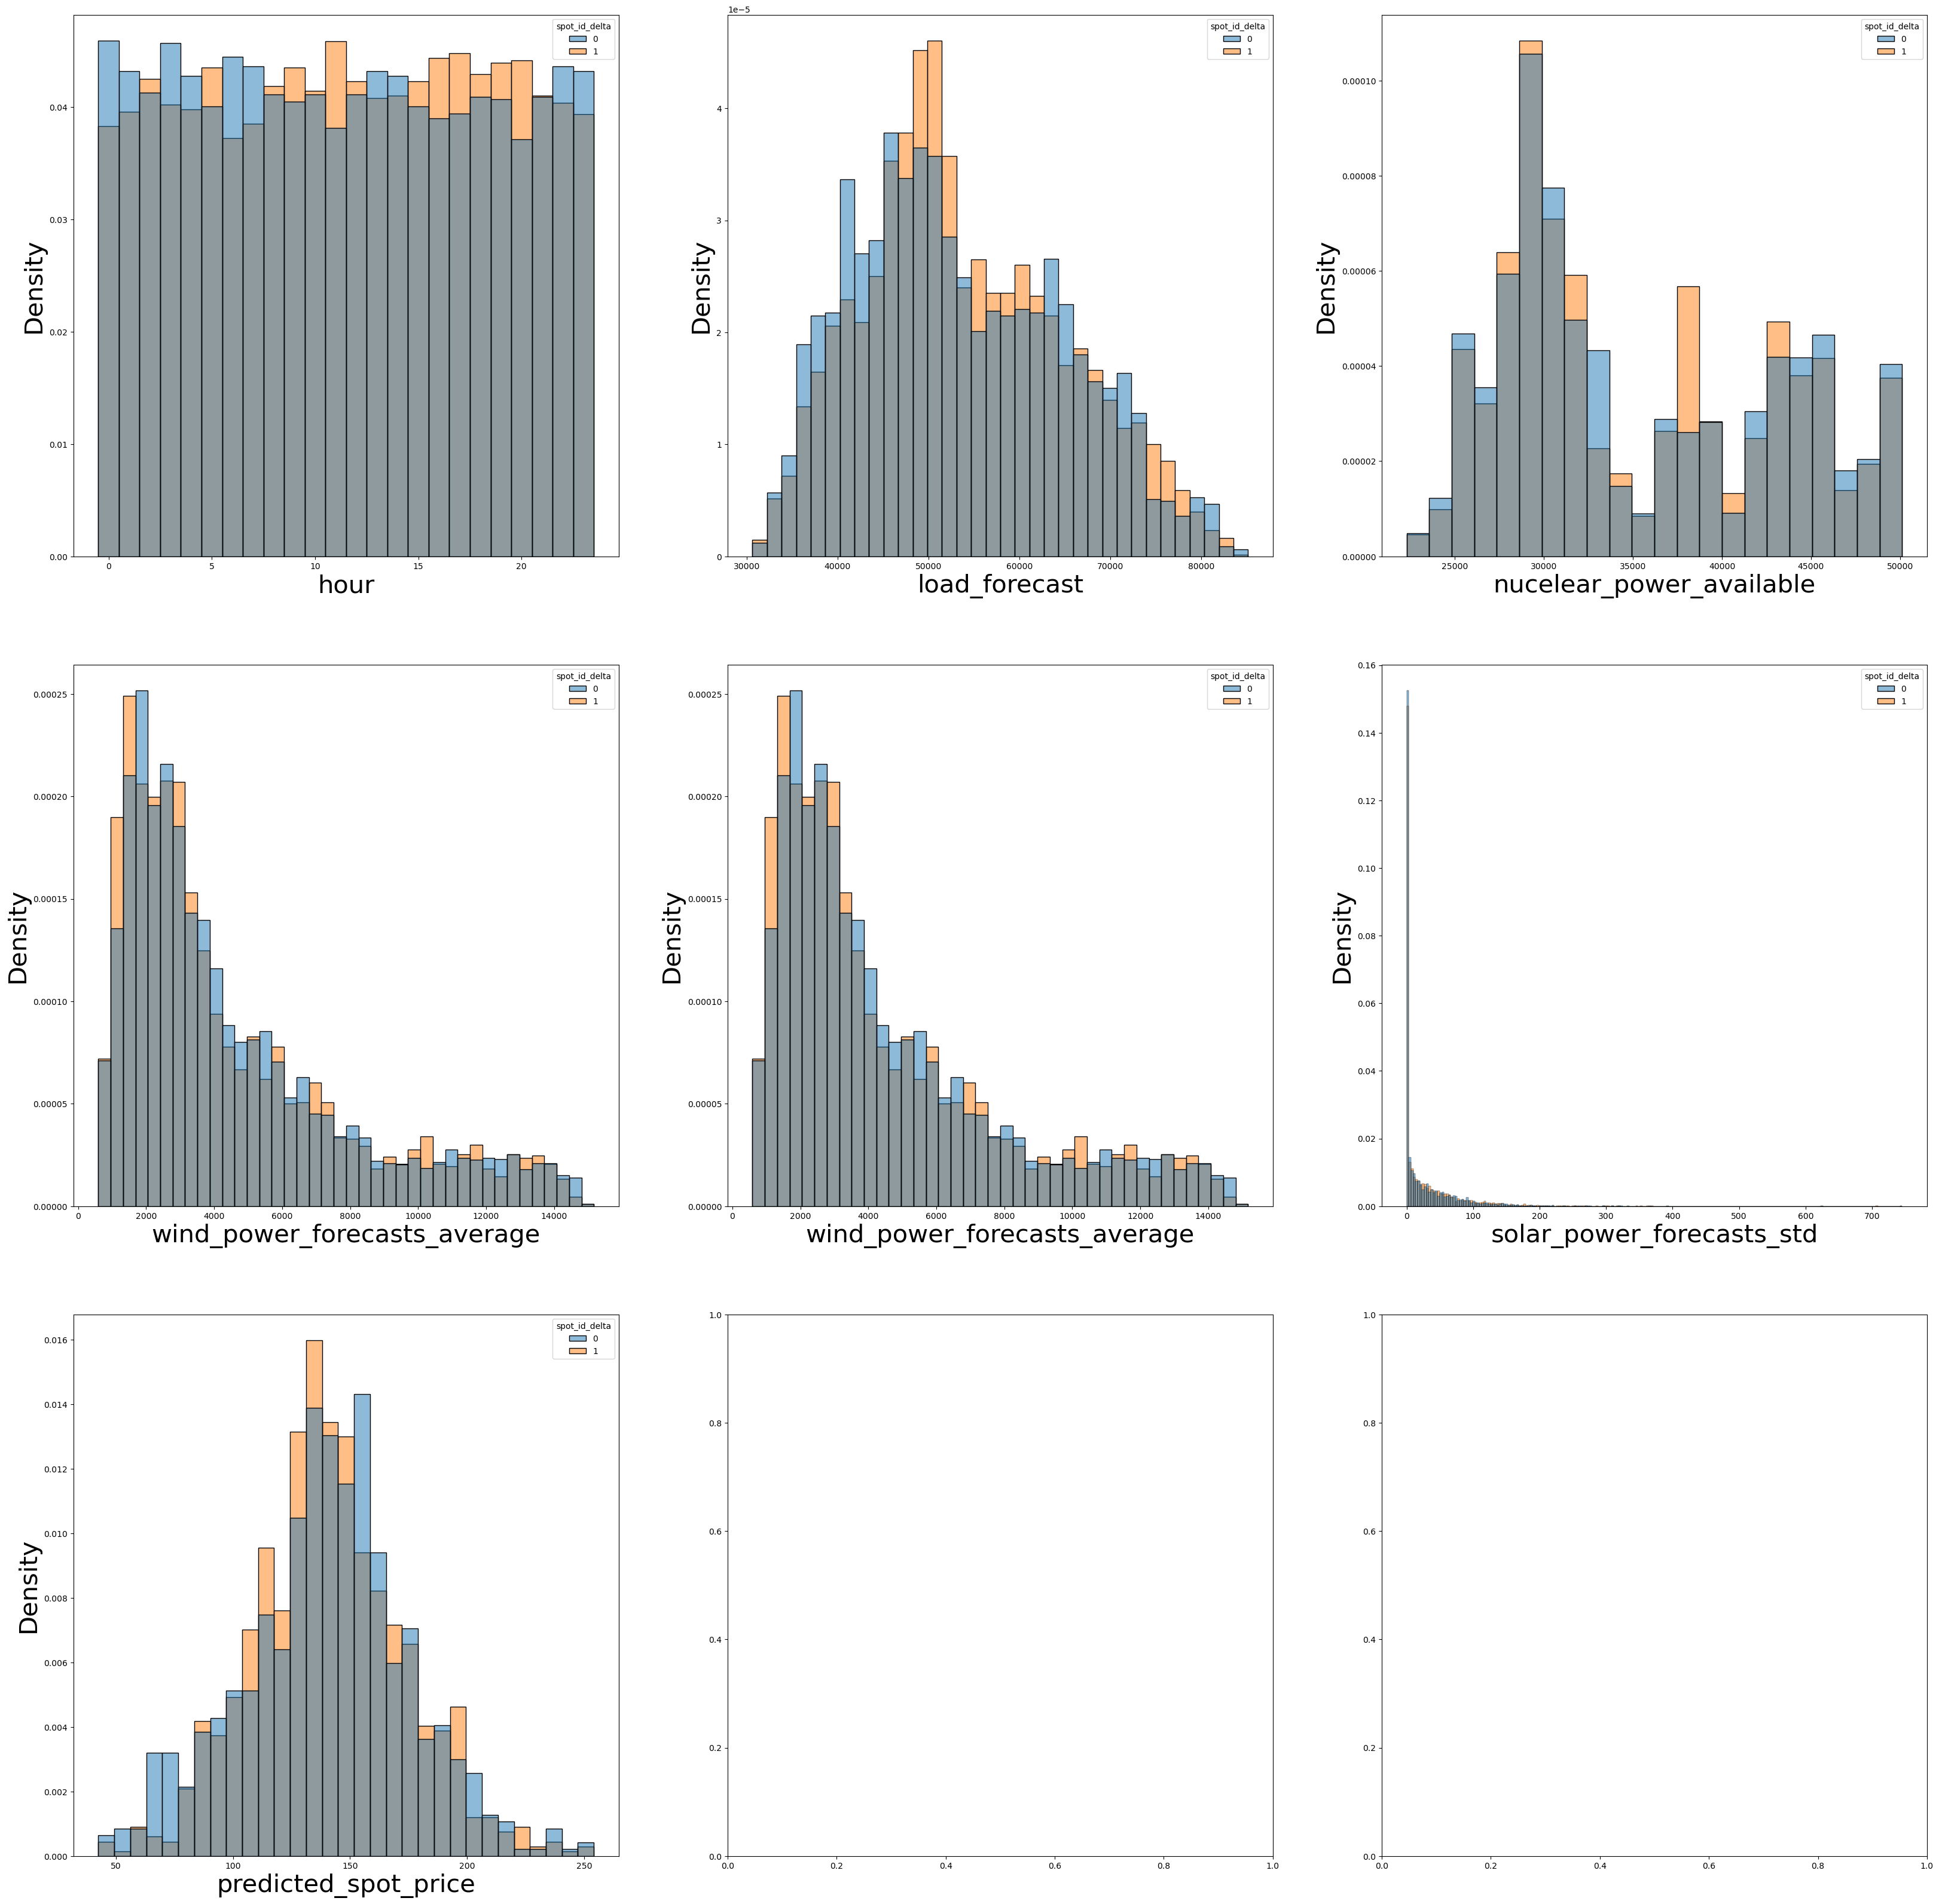

In [142]:
fig, axs = plt.subplots(3, 3, figsize=(40, 40))  # Ajustez figsize selon vos besoins
sns.histplot(data=X_train, x='hour', hue=y_train['spot_id_delta'], stat="density", common_norm=False,ax=axs[0,0])
sns.histplot(data=X_train, x="load_forecast", hue=y_train['spot_id_delta'], stat="density", common_norm=False,ax=axs[0,1])
sns.histplot(data=X_train, x="nucelear_power_available", hue=y_train['spot_id_delta'], stat="density", common_norm=False,ax=axs[0,2])
sns.histplot(data=X_train, x='wind_power_forecasts_average', hue=y_train['spot_id_delta'], stat="density", common_norm=False,ax=axs[1,0])
sns.histplot(data=X_train, x='wind_power_forecasts_average', hue=y_train['spot_id_delta'], stat="density", common_norm=False, ax=axs[1,1])
sns.histplot(data=X_train, x='solar_power_forecasts_std', hue=y_train['spot_id_delta'], stat="density", common_norm=False,ax=axs[1,2])
sns.histplot(data=X_train, x='predicted_spot_price', hue=y_train['spot_id_delta'], stat="density", common_norm=False,ax=axs[2,0])

for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)


plt.show()

In [155]:
#random forest
numerical_transformer_whithout_scaler = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),

])

categorical_transformer_without_one_hot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocessor_just_imput = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_whithout_scaler, num_features),
        ('cat', categorical_transformer_without_one_hot, cat_features)
    ])


In [156]:
rdm_forest_clf=RandomForestClassifier()
pipeline_rdm_forest=Pipeline(steps=[('prepo',preprocessor_just_imput),('classifier',rdm_forest_clf)])

In [157]:
X_train = X_train.drop(columns=['DELIVERY_START'])

In [161]:

from sklearn.model_selection import cross_val_score, KFold
def weighted_accuracy(y_true, y_pred):
    # Vérifier si le sens de la prédiction correspond au sens réel
    correct_sign = np.sign(y_true) == np.sign(y_pred)
    
    # Calculer les poids (valeur absolue des écarts réels)
    weights = np.abs(y_true)
    
    # Calculer la Weighted Accuracy
    weighted_accuracy = np.sum(correct_sign * weights) / np.sum(weights)
    # Calculer l'accuracy pondérée
    return weighted_accuracy


weighted_accuracy_scorer = make_scorer(weighted_accuracy)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

# validation croisée
scores = cross_val_score(
    pipeline_rdm_forest,  
    X_train,        
    y_train["spot_id_delta"],
    cv=kf,          
    scoring=weighted_accuracy_scorer  
)


print("Scores de validation croisée (Weighted Accuracy) :", scores)
print("Moyenne des scores :", np.mean(scores))
print("Écart-type des scores :", np.std(scores))

Scores de validation croisée (Weighted Accuracy) : [0.72813488 0.74146846 0.7321238  0.74604847 0.73819302]
Moyenne des scores : 0.7371937255775695
Écart-type des scores : 0.006410075279169766
